## Wavenet

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocab
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [100]:
block_size = 8 # context length: how many chars do we take to predict the next one

# build dataset
def build_dataset(words):
    
    X, Y = [], []
    for w in words:
#         print(w)

        context = [0]* block_size
        for ch in w+'.':
            idx = stoi[ch]
            X.append(context)
            Y.append(idx)
            context = context[1:] + [idx]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [101]:
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_train, Y_train = build_dataset(words[:n1])  #80%
X_eval, Y_eval = build_dataset(words[n1:n2])  #10%
X_test, Y_test = build_dataset(words[n2:])    #10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [120]:
for x,y in zip(X_train[:20], Y_train[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->',itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [121]:
class Linear:
    def __init__(self, fan_in, fan_out, bias = True):
        self.weight = torch.randn((fan_in, fan_out)) /fan_in**0.5 # Kaiming init
        self.bias = torch.zeros(fan_out) if bias else None  #this can be set to False when using Batch Norm
        
    def __call__(self, x):
        self.out = x@self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [122]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum = 0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True   #
        
        self.gamma = torch.ones(dim)   #gain
        self.beta = torch.zeros(dim)  #bias
        # Buffers
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0,keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
            
        xhat = (x-xmean)/torch.sqrt(xvar + self.eps)
        self.out = self.gamma*xhat + self.beta
        
        #update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum*xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum*xvar
                
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]

In [123]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [124]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim) :
        self.weight = torch.randn((num_embeddings, embedding_dim))
        
    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out
    
    def parameters (self):
        return [self.weight]
    
class FlattenConsecutive: #Not the same as pytorch
    def __init__(self, n):
        self.n = n
        
    def __call__(self, x):
        B,T,C = x.shape
        x = x.view(B, T//self.n, C*self.n)
        if x.shape[1] == 1:
            x= x.squeeze(1)
        self.out = x
        return self.out
    
    def parameters (self):
        return []

In [125]:
class Sequential:
    def __init__(self, layers):
        self.layers = layers
    def __call__(self, x):
        for layer in self. layers:
            x = layer(x)
            self.out = x
        return self.out
    def parameters (self):
    # get parameters of all layers and stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters ()]

In [126]:
torch.manual_seed(42)

In [127]:
dim_emb = 10
dim_hidden = 200
# g= torch.Generator().manual_seed(2147483647)

# C = torch.randn((vocab_size, dim_emb))   #embedding

C.shape

torch.Size([27, 10])

In [128]:
model = Sequential([
    Embedding(vocab_size, dim_emb),
    FlattenConsecutive(block_size),
    Linear(dim_emb *block_size, dim_hidden, bias=False), BatchNorm1d(dim_hidden), Tanh(),
    Linear(dim_hidden, vocab_size),
])
with torch.no_grad():
    model.layers[-1].weight *=0.1

    
parameters = model.parameters()

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

22097


In [129]:

max_steps = 200000
batch_size = 32
lossi = []

In [130]:
for i in range(max_steps):

    # Construct Minibatch
    idx = torch.randint(0, X_train.shape[0], (batch_size,))
    Xb,Yb = X_train[idx], Y_train[idx]
    
    #Forward Pass

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    
    #backward
    for layer in layers:
        layer.out.retain_grad()  #AFTER DEBUG: would take out retain _grad
    
    for p in parameters:
        p.grad = None
    loss.backward()

    #update
    lr = 10**-2 if i > 150000 else 10**-1
    for p in parameters:
        p.data += -lr * p.grad
        
    if i % 10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        
    lossi.append(loss.log10().item())
#     break
    
print(loss.item())

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6869
 170000/ 200000: 2.0965
 180000/ 200000: 1.7823
 190000/ 200000: 1.9150
2.0049266815185547


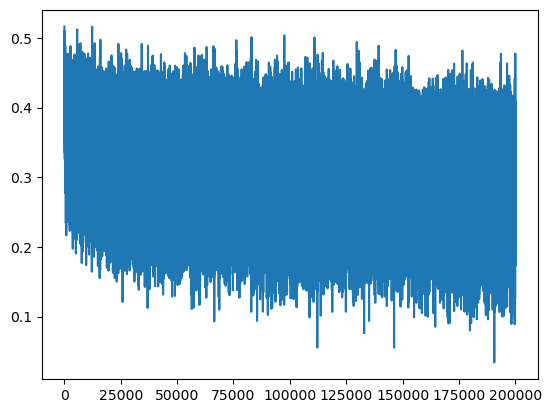

In [131]:
plt.plot(lossi)

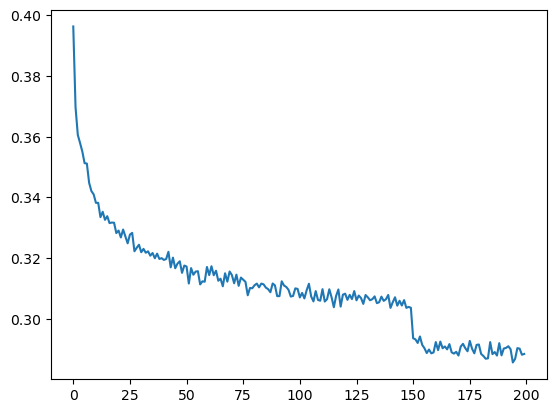

In [132]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [133]:
#put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [134]:
@torch.no_grad()  #this decorator disables gradient tracking (required_grad = False)

def split_loss(split):
    x,y = {
        'train':(X_train, Y_train),
        'val': (X_eval, Y_eval),
        'test': (X_test, Y_test),
    }[split]
    
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 1.9163451194763184
val 2.034252166748047


In [135]:
for _ in range(20):

    out = []
    context = [0] *block_size
    while True:
        
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        idx = torch.multinomial(probs, num_samples = 1).item()
        context = context[1:] + [idx]
        out.append(itos[idx])
#         print(idx)
        if idx == 0:
            break
    print(''.join(out))

yeverii.
kya.
kylek.
tisire.
porbyn.
abib.
merighlynn.
loriel.
jiildy.
davryah.
brone.
thorder.
nyleah.
miromell.
oluwase.
josusas.
ramia.
herlio.
delina.
maclai.


### Performance Log

original (3 chars context + 200 hidden, 12K params) train 2.058, val 2.105